## Estimating noise and stabilizing variance in calcium imaging data

The purpose of this notebook is to show how to use the VST transform for estimating the noise profile of calcium imaging data and apply a generalized Anscombe transform that aims to transform the noise into white Gaussian.

In [1]:
get_ipython().magic('load_ext autoreload')
get_ipython().magic('autoreload 2')

import logging
import matplotlib.pyplot as plt
import numpy as np
import os
import timeit

logfile = None # Replace with a path if you want to log to a file
logger = logging.getLogger('caiman')
# Set to logging.INFO if you want much output, potentially much more output
logger.setLevel(logging.WARNING)
logfmt = logging.Formatter('%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s')
if logfile is not None:
    handler = logging.FileHandler(logfile)
else:
    handler = logging.StreamHandler()
handler.setFormatter(logfmt)
logger.addHandler(handler)

import caiman.external.houghvst.estimation as est
from caiman.external.houghvst.gat import compute_gat, compute_inverse_gat
import caiman as cm
from caiman.paths import caiman_datadir

/tmp/ipykernel_20976/2794318978.py:1: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('load_ext autoreload')
/tmp/ipykernel_20976/2794318978.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('autoreload 2')
2025-06-12 22:45:35.626663: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 22:45:35.626692: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 22:45:35.626701: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regis

Below is a function that will compute and apply the transformation and its inverse. The underlying noise model is scaled Poisson plus Gaussian, i.e., the underlying fluorescence value $x$ is related to the observed value $y$ by the equation

$$y = \alpha*\text{Poisson}(x) + \varepsilon$$

where $\alpha$ is non-negative scalar, and $\varepsilon \sim \mathcal{N}(\mu,\sigma^2)$ is distributed according to a Gaussian distribution.

In [17]:
def main():
    fnames = '/home/janwillem/Data/voltage_HPC2/HPC2/00_02.tif'

    movie = cm.load(fnames,subindices=slice(0,200))
    movie = movie.astype(float)

    # makes estimation numerically better:
    movie -= movie.mean()

    # use one every 200 frames
    temporal_stride = 100
    # use one every 8 patches (patches are 8x8 by default)
    spatial_stride = 6

    movie_train = movie[::temporal_stride]

    t = timeit.default_timer()
    estimation_res = est.estimate_vst_movie(movie_train, stride=spatial_stride)
    print('\tTime', timeit.default_timer() - t)

    alpha = estimation_res.alpha
    sigma_sq = estimation_res.sigma_sq

    movie_gat = compute_gat(movie, sigma_sq, alpha=alpha)
    # save movie_gat here
    movie_gat_inv = compute_inverse_gat(movie_gat, sigma_sq, alpha=alpha,
                                        method='asym')
    # save movie_gat_inv here
    return movie, movie_gat, movie_gat_inv

In [18]:
movie, movie_gat, movie_gat_inv = main()

	initial alpha = 5.383076312763208; sigma^2 = 1418.6445466975263
	Highest score= 203.45759739225832
	mid alpha = 2.593664041604091; sigma^2 = 1034.8061628591424
	Highest score= 212.94753025226748
	alpha = 2.6548353633400366; sigma^2 = 1036.8263648793445
	Time 20.153177213000163


The transformed movie should have more uniform dynamic range (press `q` to exit):

In [19]:
movie_gat.play(magnification=4, q_max=99.8)

The movie might appear more noisy but information is preserved as seen from the correlation image:

Text(0.5, 1.0, 'Correlation Image (transformed)')

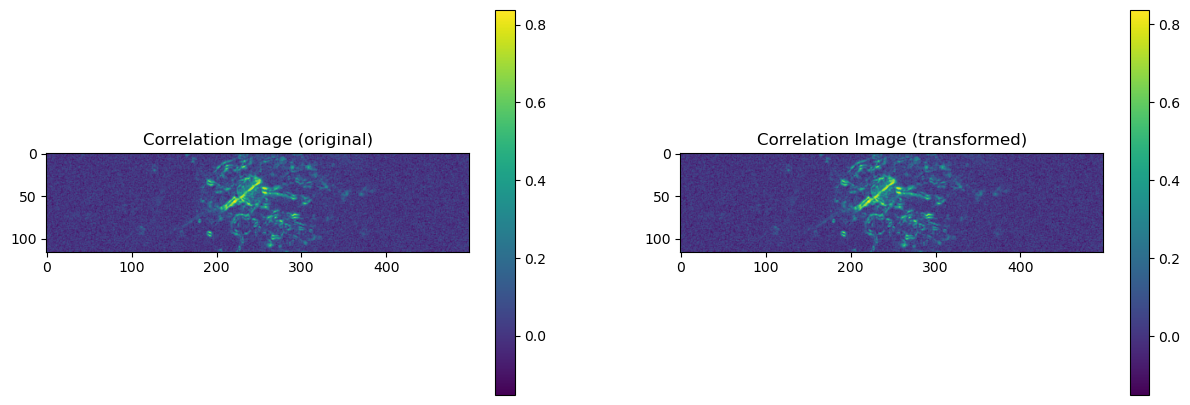

In [20]:
CI = movie.local_correlations(swap_dim=False)
CI_gat = movie_gat.local_correlations(swap_dim=False)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(CI); plt.colorbar(); plt.title('Correlation Image (original)')
plt.subplot(1,2,2); plt.imshow(CI_gat); plt.colorbar(); plt.title('Correlation Image (transformed)')

The noise estimates in space should also be more uniform

Text(0.5, 1.0, 'Noise standard deviation (transformed)')

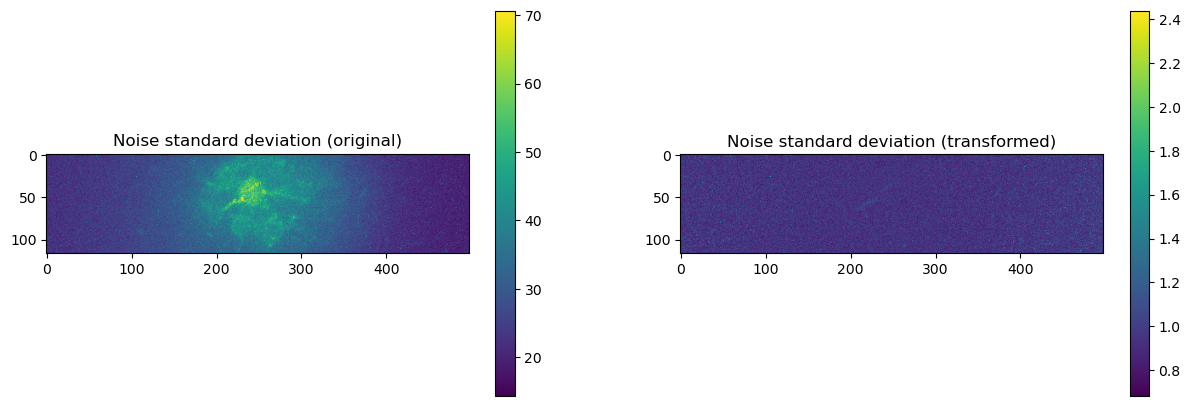

In [21]:
sn = cm.source_extraction.cnmf.pre_processing.get_noise_fft(movie.transpose(1,2,0), noise_method='mean')[0]
sn_gat = cm.source_extraction.cnmf.pre_processing.get_noise_fft(movie_gat.transpose(1,2,0), noise_method='mean')[0]
# sn = np.std(movie.transpose(1,2,0), axis=-1)
# sn_gat = np.std(movie_gat.transpose(1,2,0), axis=-1)
plt.figure(figsize=(15,5))
plt.subplot(1,2,1); plt.imshow(sn); plt.colorbar(); plt.title('Noise standard deviation (original)')
plt.subplot(1,2,2); plt.imshow(sn_gat); plt.colorbar(); plt.title('Noise standard deviation (transformed)')

If we apply the inverse transform we approximately get back the original movie (press `q` to exit):

In [23]:
cm.concatenate([movie,movie_gat_inv],axis=2).play(magnification=5, q_max=99.5)

In [26]:


movie_gat_inv.save('/home/janwillem/Data/voltage_HPC2/HPC2/00_02_t.tif')

'/home/janwillem/Data/voltage_HPC2/HPC2/00_02_t.tif'